<h1> Ajuste de modelos a pandemia COVID-19</h1>

El siguiente código descarga datos actuales de la enfermedad los almacena en archivos csv e intenta ajustar los parametros de un modelo SIRD a los datos.

**Problema 1:** En la base de datos de internet no hay datos de Estados Unidos.


**Problema 3:** Mas del proceso de modelización. Las soluciones del modelo SIRD parece tener una forma que no se corresponde con los datos de la realidad. En el sentido que la duración de la epidemia parece más corta en los modelos.

In [1]:
import numpy as np
from scipy.integrate import odeint 
import matplotlib.pyplot as plt

<h2> Buscando datos de la enfermedad </h2>

Sitio: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

In [2]:
import requests

In [3]:
################################################################
###  Descarga datos actuales de internet  desde John Hopskins###
####  Cambiar la variable MiDirectorio con el directorio que se desaea trabajar

MiDirectorio='/home/fernando/fer/Investigación/Trabajo en curso/corona/'


urlb='https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2F'
url1 = 'time_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
url2 = 'time_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv'
url3 = 'time_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv'


myfile = requests.get(urlb+url1)
open(MiDirectorio+'DataConfirmados.csv', 'wb').write(myfile.content)

myfile = requests.get(urlb+url2)
open(MiDirectorio+'DataMuertos.csv', 'wb').write(myfile.content)

myfile = requests.get(urlb+url3)
open(MiDirectorio+'DataRecuperados.csv', 'wb').write(myfile.content)

In [4]:
############Para leer datos descargados
import csv

In [5]:

### Los primeros 4 items de la fila son vacio,
### nombre del país, lat, long. No los usamos
### OJO: en los datos de la tabla hay valores acumulados de infectados, en los modelos
### cuentan los  infectados activos 
### Infectados Activos= Infectados Acumulados-(muertos+recuperados)

### S_data,I_data,M_data,R_data=ExtraerDatos(IndPais,Poblacion)
### IndPais = Fila del pais-región
### Poblacion=Total de habitantes
### S_data,I_data,M_data,R_data Datos de Susceptibles, infecciosos, muertes y recuperados


def ExtraerDatos(Pais,Poblacion):
    with open('DataConfirmados.csv') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if Pais in row:
                I_data_acum=np.array([float(i) for i in row[5:]])
    with open('DataMuertos.csv') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if Pais in row:
                M_data=np.array([float(i) for i in row[5:]])
    with open('DataRecuperados.csv') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if Pais in row:
                R_data=np.array([float(i) for i in row[5:]])
    i0=min(len(I_data_acum),len(M_data),len(R_data))
    I0=range(i0)
    I_data_acum=I_data_acum[I0]
    R_data=R_data[I0]
    M_data=M_data[I0]
    I_data=I_data_acum-(M_data+R_data)
    S_data=PoblacionArg-I_data_acum #S=Poblacion-Infectados Acumulados

    #Extraemos datos desde el comienzo de la epidemia
    
    Ind=I_data_acum>0
    I_data_acum=I_data_acum[Ind]
    I_data=I_data[Ind]
    M_data=M_data[Ind]
    R_data=R_data[Ind]
    S_data=S_data[Ind]
    return S_data,I_data,M_data,R_data,I_data_acum

### Argentina es la fila 7 de las tablas 
PoblacionArg=44.49e6  #Segun wikipedia
IndArg=7

S_data,I_data,M_data,R_data,I_data_acum=ExtraerDatos('Argentina',PoblacionArg)


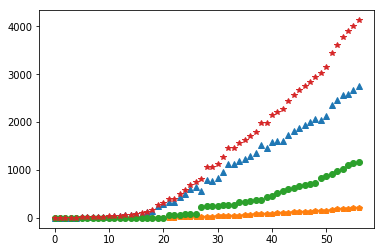

In [6]:
plt.plot(I_data,'^',M_data,'p',R_data,'o',I_data_acum,'*')

<h2> Modelo SIRD </h2>

<b> Bibliografía </b>

[BCF2019] "Mathematical Models in Epidemiology", Fred Brauer and Carlos Castillo-Chavez and Zhilan Feng, ISBN: 978-14-9399-828-9, Springer Nature,2019.

**Modelo**

SIRD Susceptibles-Infectados-Recuperados y Muertos por la enfermedad
ver sección 2.5 de [BCF2019]

$$
\begin{aligned}
&S^{\prime}=-\beta S I\\
&I^{\prime}=\beta S I-(\alpha+d) I\\
&R^{\prime}=\alpha I
\end{aligned}
$$

$$\begin{aligned}
\frac{1}{\alpha}&=\text{periodo infecciosidad medio}\\
\beta&=\text{cantidad de contactos por individuo por unidad de tiempo}\\
d&=\text{tasa de mortalidad}\\
\mathcal{R}_0&=\frac{\beta N}{\alpha+d}=\text{número reproducción básico}\\
            &=\text{Cantidad infecciones a lo largo de la vida de}\\
            &\text{un infeccioso dentro de una población de sólo susceptibles}\\
\end{aligned}
$$


Sólo es necesario modelar las primeras dos ecuaciones

In [7]:
def SIRD(Y,t,alpha,beta,d):
    S,I,R=Y
    dSdt=-beta*S*I
    dIdt=beta*S*I-(alpha+d)*I
    dRdt=alpha*I
    return dSdt,dIdt,dRdt
####### Resolvemos el modelos
def ModeTeor(t,alpha,beta,d,y0):
    sol = odeint(SIRD,y0 ,t, args=(alpha,beta,d))
    return sol

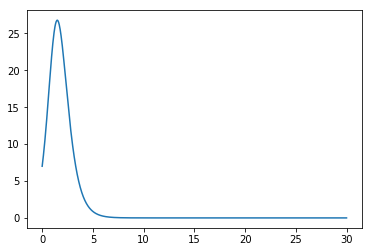

In [8]:
##########Ejemplo################
########## Plaga Eyam, peste bubónica ver seccion 2.4 de [BCF2019]
####alpha=2.73, beta=0.017, d=0
##En realidad hay defiunsiones, se computan con R

Y0=[254,7,0]
t = np.linspace(0,30, 1000)
argus=(2.73, 0.017,0)

sol = odeint(SIRD,Y0 ,t, args=argus)
S,I=sol[:,0],sol[:,1]
plt.plot(t,I)
plt.show()

<h2> Ajuste de los parámetros </h2>

Usaremos el submódulo de optimizacion de la librería SciPy

In [9]:
import scipy.optimize


In [10]:
def error_Mod(x,*params):
    alpha,R0,d=x
    t,S_data,I_data,R_data,Poblacion=params
    beta=(alpha+d)*R0/Poblacion
    y0=S_data[0],I_data[0],R_data[0] #Condicion Inicial
    Sol=ModeTeor(t,alpha,beta,d,y0)
    I=Sol[:,1]
    S=Sol[:,0]
    R=Sol[:,2]
    return max(np.abs(I_data-I))#+max(np.abs(S_data-S))

def HallarParametros(t,S_data,I_data,R_data,Poblacion,rangos):

    ## Usaremos la búsqueda de un mínimo global mediate fuerzar bruta, 
    ## Busqueda en todo el rango

    
    opt=scipy.optimize.brute(error_Mod,rangos,args=(t,S_data,I_data,R_data,Poblacion),finish=None,full_output=True)
    para_opt,feval=opt[0:2]
    #para_opt= scipy.optimize.basinhopping(error_Mod, (1/30.0,2.0,.02))
    #para_opt= scipy.optimize.minimize(error_Mod,(1/30.0,2.0,.02),method='L-BFGS-B', bounds=rangos)
    return para_opt,feval

def AjusteEpidemia(Pais,Poblacion,*arg):
    S_data,I_data,M_data,R_data,I_data_acum=ExtraerDatos(Pais,Poblacion)   
    for ar in arg:
        S_data=S_data[ar]
        I_data=I_data[ar]
        M_data=M_data[ar]
        R_data=R_data[ar]
        I_data_acum=I_data_acum[ar]
    t=np.arange(0,np.shape(I_data)[0],1)
    #rangos = (slice(1/30.0,1/5.0,0.001), slice(1, 4, 0.1), slice(0.001,0.01,.001))
    rangos=(1.0/25.0,1/5.0), (1.0, 4.0), (0.001,0.01)
    para_opt,feval=HallarParametros(t,S_data,I_data,R_data,Poblacion,rangos)
    alpha,R0,d=para_opt
    beta=R0/Poblacion*(alpha+d)
    y0=S_data[0],I_data[0],R_data[0] #Condicion Inicial
    Sol=ModeTeor(t, alpha,beta,d,y0)
    I=Sol[:,1]
    S=Sol[:,0]
    R=Sol[:,2]
    plt.plot(t,I ,t,I_data,'o')
    print('alpha='+str(para_opt[0])+'\n'+'R_0='+str(para_opt[1])+'\n'+'d='+str(para_opt[2]))
    print('Error Max='+str(feval))
    f=lambda t: ModeTeor(t,alpha,beta,d,y0)
    return f


<h2> Experimento 1. Argentina </h2>

alpha=0.09894736842105263
R_0=2.4210526315789473
d=0.005263157894736842
Error Max=1240.0751940312464


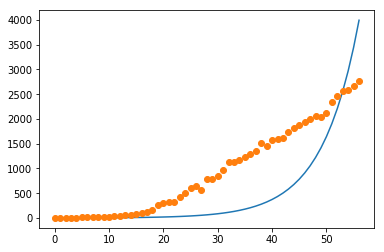

In [11]:
f=AjusteEpidemia('Argentina',44.49e6)

alpha=0.2
R_0=2.4210526315789473
d=0.0024210526315789475
Error Max=11.247812993626486


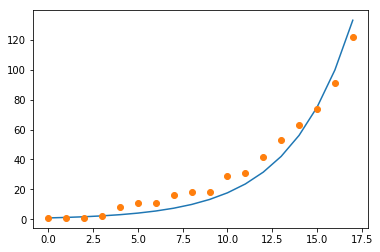

In [12]:
f=AjusteEpidemia('Argentina',44.49e6,range(18))

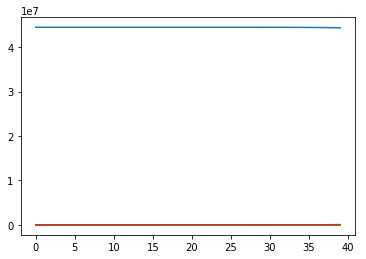

In [13]:
t=np.arange(0,40,1)
Y=f(t)
S,I,R=Y[:,0],Y[:,1],Y[:,2]
M=44.49e6-S-I-R
plt.plot(t,S,t,I,t,R,t,M)


<h2> Experimento 2. Italia </h2>

alpha=0.12421052631578947
R_0=2.7368421052631575
d=0.003842105263157895
Error Max=82362.38649358109


<function __main__.<lambda>>

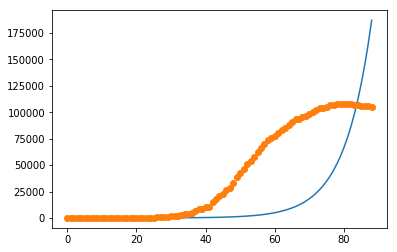

In [14]:
AjusteEpidemia('Italy', 60.36e6)

alpha=0.11578947368421053
R_0=3.8421052631578947
d=0.0024210526315789475
Error Max=510.2668586983036


<function __main__.<lambda>>

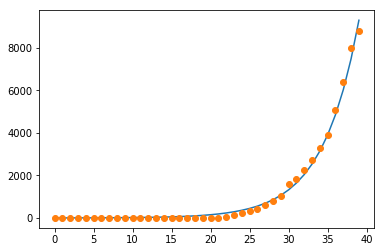

In [15]:
AjusteEpidemia('Italy', 60.36e6,range(40))

<h2> Experimento 3. España  </h2>

alpha=0.08210526315789474
R_0=2.7368421052631575
d=0.00431578947368421
Error Max=75811.44656779699


<function __main__.<lambda>>

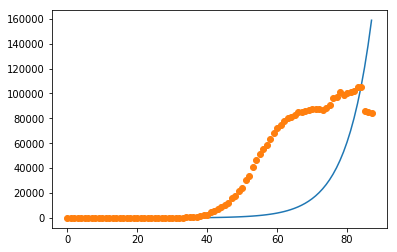

In [16]:
AjusteEpidemia('Spain', 46.94e6)

alpha=0.14947368421052631
R_0=2.4210526315789473
d=0.008105263157894737
Error Max=1460.4920398167123


<function __main__.<lambda>>

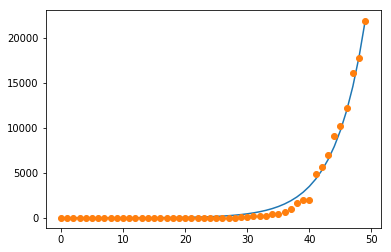

In [17]:
AjusteEpidemia('Spain', 46.94e6,range(50))

<h2> Experimento 4. Brasil  </h2>

alpha=0.2
R_0=1.9473684210526314
d=0.0076315789473684215
Error Max=18090.751140634333


<function __main__.<lambda>>

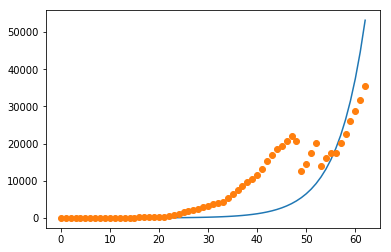

In [18]:
AjusteEpidemia('Brazil', 46.94e6)

alpha=0.09052631578947368
R_0=3.526315789473684
d=0.00668421052631579
Error Max=4066.1061781776416


<function __main__.<lambda>>

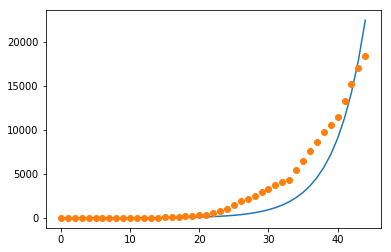

In [19]:
AjusteEpidemia('Brazil', 46.94e6,range(45))

<h2> Conclusiones </h2>

Pareciera que el modelo ajusta mejor desde el día cero hasta el comienzo de la cuarentena.

Hay que buscar un modelo que contemple la cuarentena